# Гистограммные преобразования. Эквализация.

**Автор:** 22.М04, Винник Екатерина Петровна

**Задание:**: преобразовать и показать как изображения, так и гистограммы –- исходные и то, что получилось.
- [+] глобальная
- [+] локальная, с параметром -- размер окна.

Гистограммой изображения с уровнями яркости в диапазоне $[0, L - 1]$ называется функция  $h(r_k) = n_k$, где $r_k$ -- $k-й$ уровень яркости, а $n_k$ -- число пикселей на изображении, имеющих яркость $r_k$. 

Общей практикой является нормализация гистограммы с помощью деления каждого из значений на общее число пикселей в изображении, т.е., $p(r_k) = n_k/n$ для $k=0,1..$.

В дискретном случае преобразование, задаваемое уравнением 
$$
\begin{equation}
s_k = T(r_k) = \sum_{j = 0}^k p_r(r_j)    \\                      
k = 0,1,2..L-1
\end{equation}
$$ 
называется линеаризацией, или эквализацией гистограммы. Функция преобразования $T(r)$ при этом считается удовлетворяющей следующим условиям:
- $T_r$ является однозначной и монотонно возрастающей на интервале $0 <= r <= 1$
- $0 <= T(r) <= 1$ при $0 <= r < =1$

### Гистограмма

Воспользовавшись определением гистограммы, приведенным ранее, можем реализовать функцию *build_histogram*

In [1]:
import numpy as np

def build_histogram(img, normalize=True):
    Lm1 = 256
    hist_arr = np.zeros((Lm1))
    for rk in range(Lm1):
        where_rk = np.argwhere(img == rk)
        hist_arr[rk] = where_rk.shape[0]
            
    if normalize:
        h = img.shape[0]
        w = img.shape[1]
        hist_arr /= (h * w)
        
    return hist_arr

### Эквализация гистограммы

In [2]:
import numpy as np


def eq_uniform(img, hist_arr):
    h = img.shape[0]
    w = img.shape[1]
    Lm1 = 256
    
    img_new = np.zeros_like(img)
    for rk in range(Lm1):
        where_rk_bin = img == rk
        hist_sum_k = np.sum(hist_arr[:rk])
        img_new[where_rk_bin] = Lm1 * hist_sum_k
            
    img_new = img_new.astype(np.uint8)
    return img_new

#### Вспомогательный метод для построения гистограммы

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def plot_hist(hist):
    if len(hist.shape) == 2:
        plt.figure(figsize=(16, 6))
        plt.bar(np.arange(256), hist[0], width=1., alpha=0.5, color='r')
        plt.bar(np.arange(256), hist[1], width=1., alpha=0.5, color='g')
        plt.bar(np.arange(256), hist[2], width=1., alpha=0.5, color='b')
    else:
        plt.figure(figsize=(16, 6))
        plt.bar(np.arange(256), hist, width=1., color='k')
        
    plt.xlabel('r_k')
    plt.ylabel('entries')
    plt.show()    

### Примеры построения гистограммы по изображению и эквализации гистограммы

Загрузим изображение для демонстрации работы функций по построению гистограммы и эквализации гистограммы.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# From R. Gonzales, R. Woods "Digital Image Processing"
img_1 = Image.open('./foo.tif')

In [5]:
# represent the images as tensors
np_1 = np.array(img_1)
print('Picture dimensions:')
print(np_1.shape)

Picture dimensions:
(500, 500)


Построим гистограмму.

In [6]:
hist_1 = build_histogram(np_1)

Рассмотрим изображение и получившуюся гистограмму.

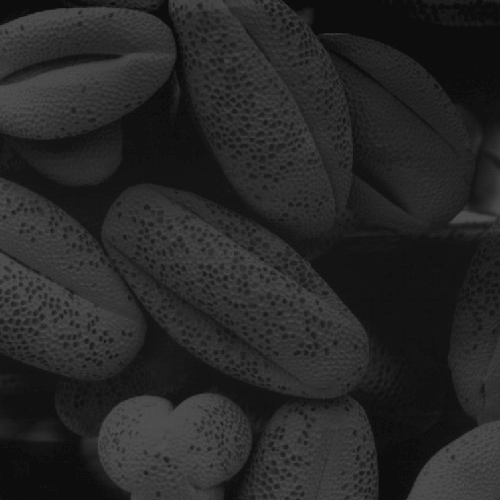

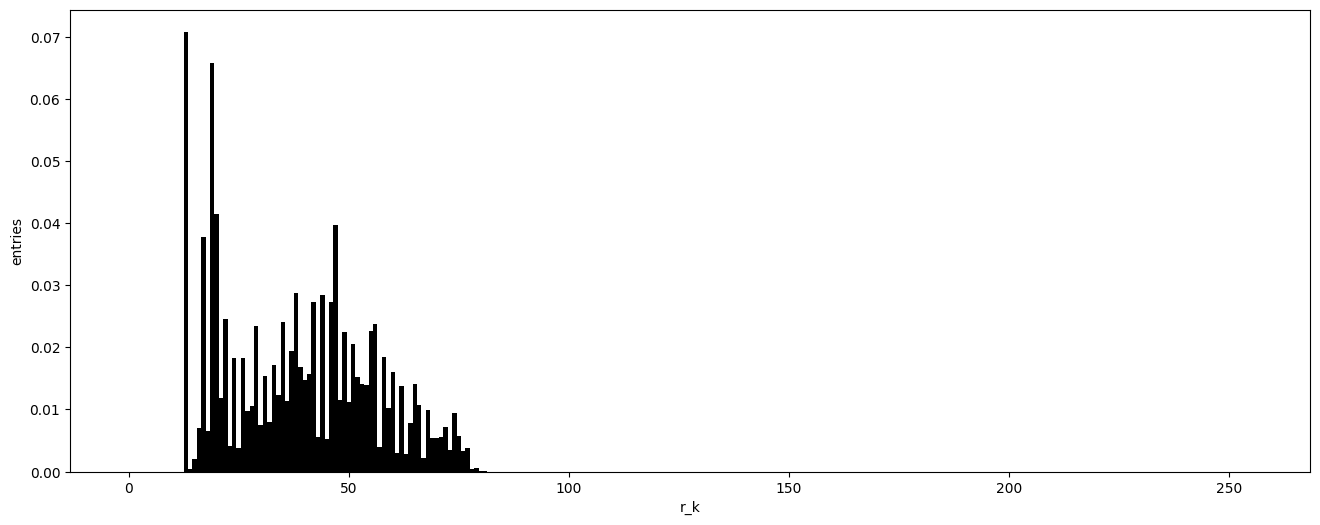

In [7]:
display(img_1)
plot_hist(hist_1)

Как видим, изображение сильно затемнено -- это видно и из изображения и из гистограммы -- большая часть пикселей изображения имеют яркости до 100.

Рассмотрим изображение в результате эквализации гистограммы.

In [8]:
np_1_new = eq_uniform(np_1, hist_1)
img_np_1_new = Image.fromarray(np_1_new.astype(np.uint8))
img_np_1_new.save('./foo_glob.png')

hist_1_new = build_histogram(np_1_new)

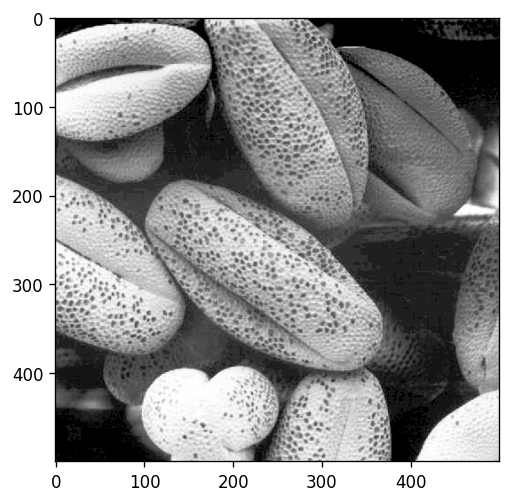

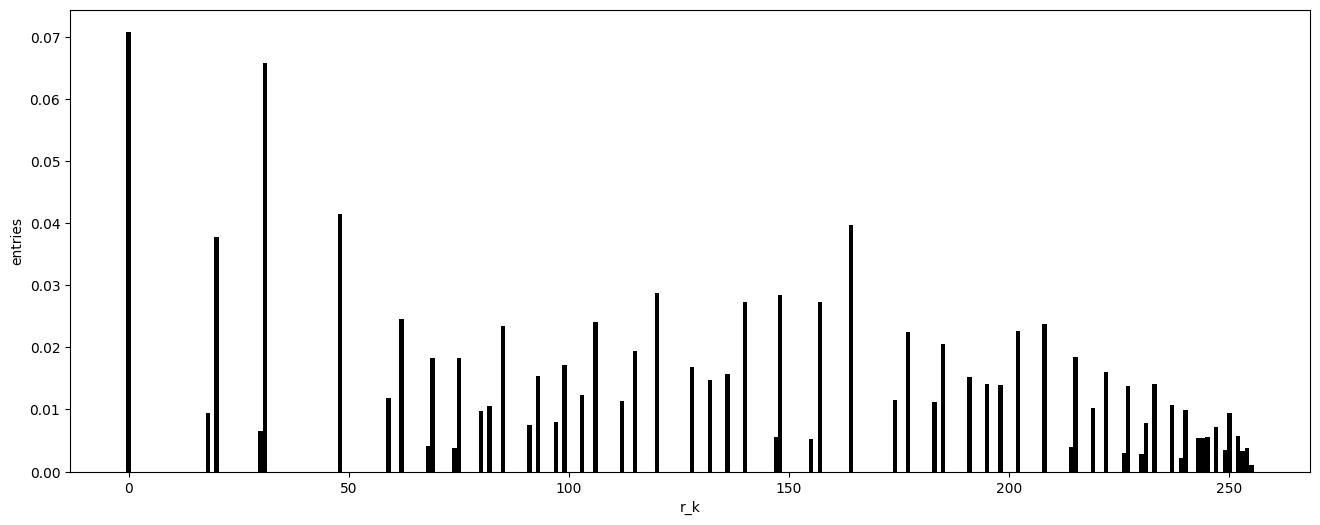

In [9]:
plt.figure(dpi=120)
plt.imshow(np_1_new, cmap='gist_gray')
plt.show()

plot_hist(hist_1_new)

### Локальная эквализация

Иногда требуется обработать не все изображение, а улучшить детали посредством анализа малых областей изображения. Это связано с тем, что число пикселей в таких областях мало и не может оказать заметного влияния на глобальную гистограмму, форма которой не обязательно соответствует локальному улучшению. Решение состоит в разработке функции преобразования, основанной на распределении яркостей (или других характеристик) по окрестности каждого элемента изображения. 

Идея локальной эквализации, где параметр -- размер окна, состоит в том, что задается форма квадратной или прямоугольной окрестности вокруг обрабатываемого элемента и затем центр этой области передвигается от точки к точке. Для каждого нового положения окрестности подсчитывается гистограмма по входящим в нее точкам и находится функция преобразования эквализации, эта функция используется для отображения уровня яркости центрального элемента окрестности. Затем центр окрестности перемещается на соседний пиксель и процедура повторяется.


Локальная эквализация, реализованная в функции *eq_uniform_local*, принимает на вход изображение и размер окна.

In [10]:
import numpy as np


def eq_uniform_local(img, window_size=3):
    h = img.shape[0]
    w = img.shape[1]
    pad_size = (window_size - 1) // 2
    Lm1 = 256
    coef = Lm1 / (window_size * window_size)
    
    img_new = np.zeros_like(img)
    
    img_padded = np.zeros((h + 2 * pad_size, w + 2 * pad_size))
    img_padded[pad_size:-pad_size, pad_size:-pad_size] = img
    for i in range(h):
        for j in range(w):
            img_loc = img_padded[i:i+window_size, j:j+window_size]
            lower_args = np.argwhere(img_loc < img_loc[pad_size, pad_size])
            img_new[i, j] = lower_args.shape[0] * coef
                
    img_new = img_new.astype(np.uint8)
    return img_new

### Сравнение результатов применения глобальной и локальной эквализации на примере

Сравним изображения, полученные в результате применения глобальной и локальной эквализации, на сглаженном изображении ниже.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# From R. Gonzales, R. Woods "Digital Image Processing"
img_21 = Image.open('./symb.tif')

In [12]:
# represent the images as tensors
np_21 = np.array(img_21)
print('Picture dimensions:')
print(np_21.shape)

Picture dimensions:
(512, 512)


Обработаем изображение и построенные гистограммы

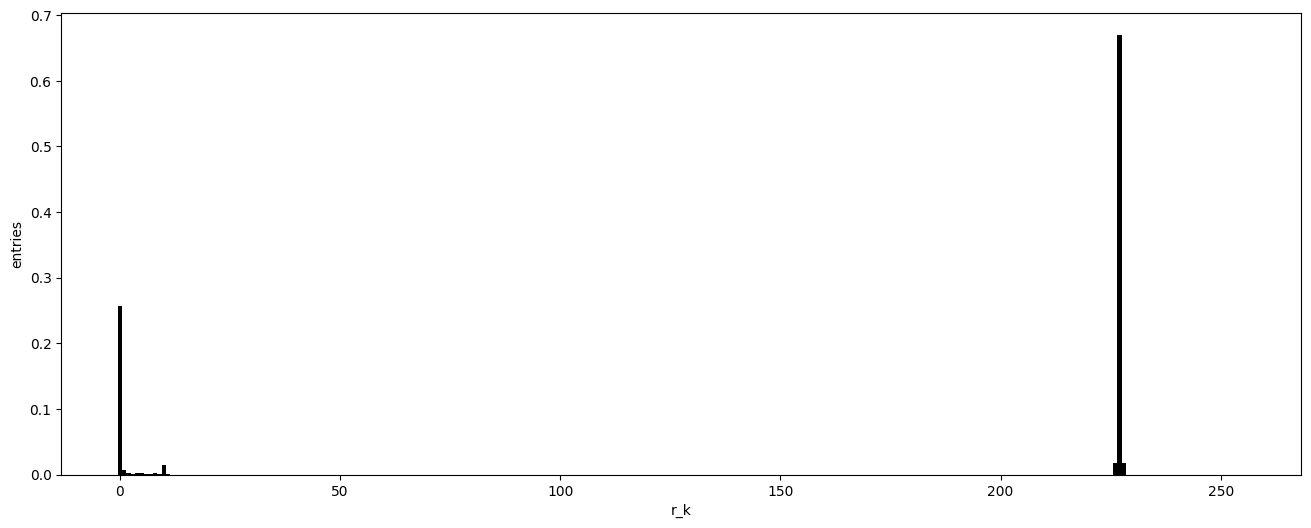

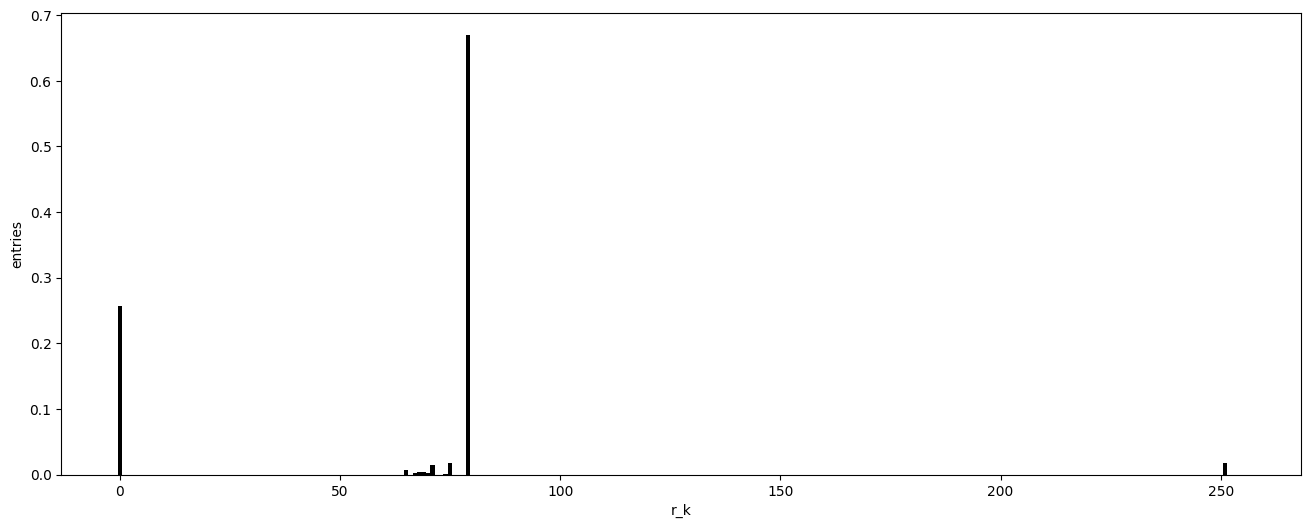

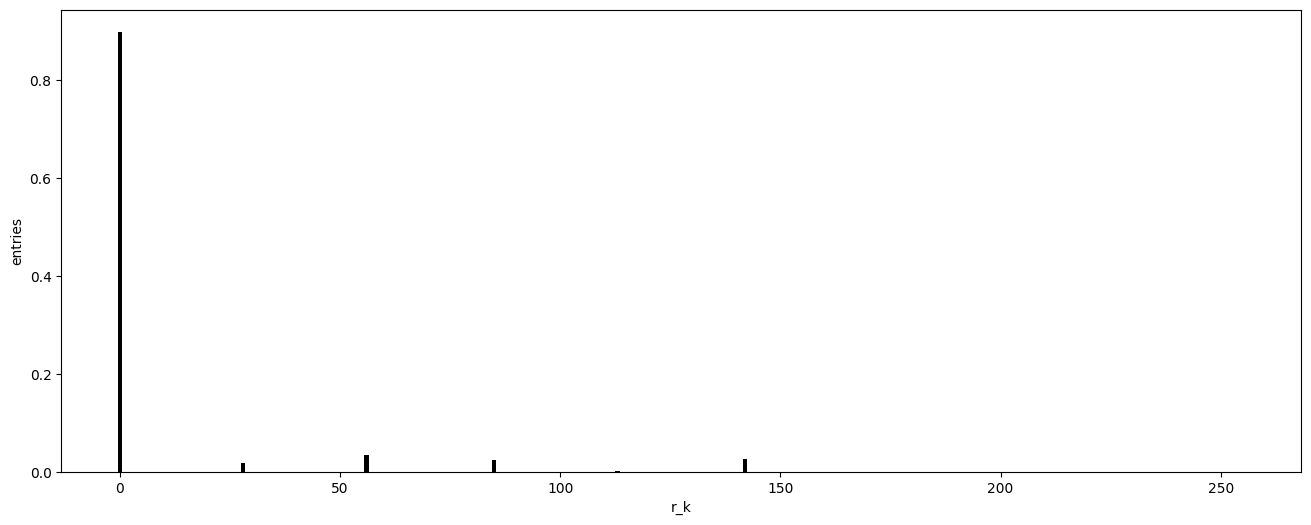

In [13]:
hist_21 = build_histogram(np_21)
plot_hist(hist_21)

np_21_glob = eq_uniform(np_21, hist_21)
img_np_21_glob = Image.fromarray(np_21_glob.astype(np.uint8))
img_np_21_glob.save('./symb_glob.png')
hist_21_glob = build_histogram(np_21_glob)
plot_hist(hist_21_glob)

np_21_loc = eq_uniform_local(np_21, 3)
img_np_21_loc = Image.fromarray(np_21_loc.astype(np.uint8))
img_np_21_loc.save('./symb_loc.png')
hist_21_loc = build_histogram(np_21_loc)
plot_hist(hist_21_loc)

Рассмотрим результаты применения эквализаций и исходное изображение:

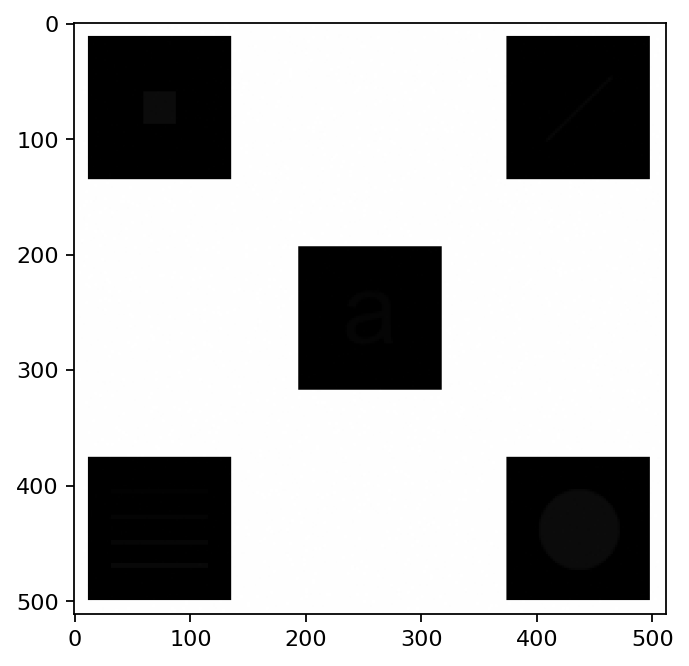

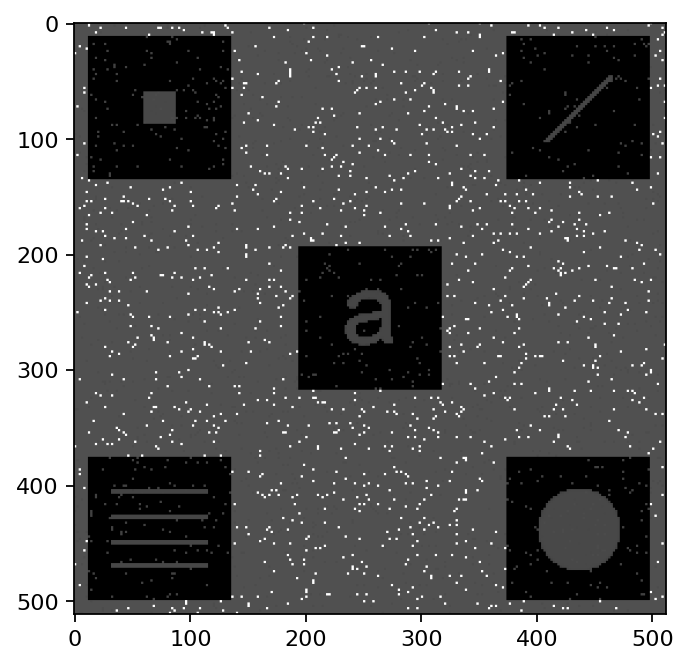

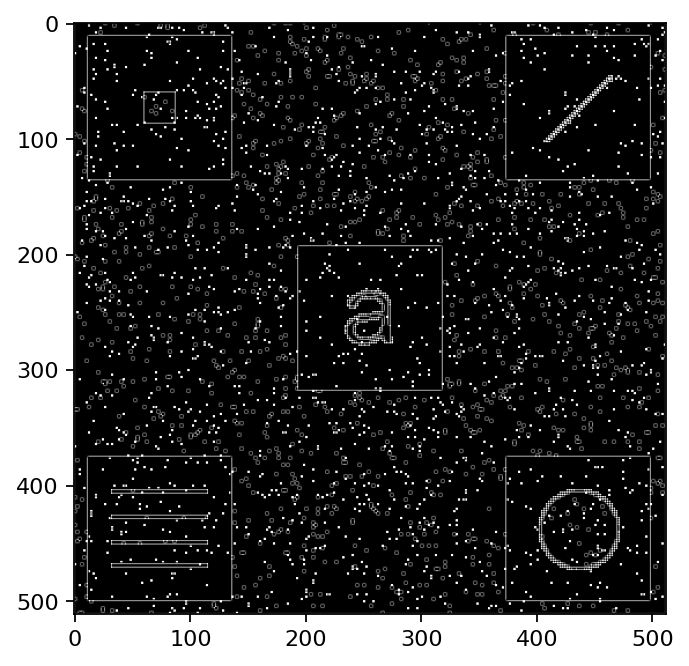

In [14]:
# исходное изображение
plt.figure(dpi=160)
plt.imshow(np_21, cmap='gray')

# изображение, полученное в результате глобальной эквализации
plt.figure(dpi=160)
plt.imshow(np_21_glob, cmap='gray')

# изображение, полученное в результате локальной эквализации
plt.figure(dpi=160)
plt.imshow(np_21_loc, cmap='gray')

Выше представлены исходное изображение, изображение, полученное в результате глобальной эквализации и изображение, полученное в результате локальной эквализации.

Применение глобальной эквализации позволяет выделить серые фигуры внутри черных квадратов, а локальная эквализация позволяет обнаружить, что фигуры внутри квадратов не являются закрашенными (чего было не достигнуть при глобальной эквализации, так как внутренние части этих фигур являются слишком маленькими элементами, чтобы заметно повлиять на форму преобразования глобальной эквализации).